### 1. Reading in James' simulation data using Pandas

In [18]:
import pandas as pd

file_path = 'dtag/grid/4_agents/4/velocity_metrics.csv'
file_path2 = 'dtag/grid/4_agents/4/idleness.csv'
file_path3 = 'dtag/grid/4_agents/4/vulnerabilities.csv'
file_path4 = 'dtag/grid/4_agents/4/distance_metrics.csv'

df_vel = pd.read_csv(file_path, sep=';', header=None)
df_idle = pd.read_csv(file_path2, sep=';',header=None)
df_vuln = pd.read_csv(file_path3, sep=';',header=None)
df_dist = pd.read_csv(file_path4, sep=';',header=None)

### 2. Cleaning and reshaping data

In [19]:
import numpy as np

N = len(df_vel.T)-1 # number of nodes in the enviroment

# remove timestep column
vel_data = df_vel.iloc[:, 1:N+1]
idle_data = df_idle.iloc[:, 1:N+1].copy() # use copy to avoid modifcation warning
idle_data[idle_data < 0] = np.nan # set negative idle values to NaN for later removal
vuln_data = df_vuln.iloc[:, 1:N+1]
dist_data = df_dist.iloc[:, 1:N+1]

# combine datasets 
df = pd.concat([vel_data,idle_data,dist_data,vuln_data],axis=1)
df = df.replace([np.inf, -np.inf], np.nan) # set all inf values to NaN for later removal

# Drop rows with NaN values
df = df.dropna()

# attack length threshold to determine attack success and update to binary classification:
threshold = 50
for col in range(N*3,N*4):
    df.iloc[:, col] = (df.iloc[:, col] >= threshold).astype(int)

# convert data to array
dataset = df.to_numpy()

# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
trainX, trainY, testX, testY = dataset[0:train_size,0:-N], dataset[0:train_size,N*3:N*4],dataset[train_size:len(dataset),0:-N], dataset[train_size:len(dataset),N*3:N*4] 
#split is appropriate as it trains on the first set of timestep values

# reshape data to appropriate format as (timestep, number of nodes, number of features)
trainX = np.reshape(trainX, (trainX.shape[0],trainX.shape[-1]//3,3))
testX = np.reshape(testX, (testX.shape[0],testX.shape[-1]//3,3))

### 3. Create adjacency matrix for data's respective enviroment

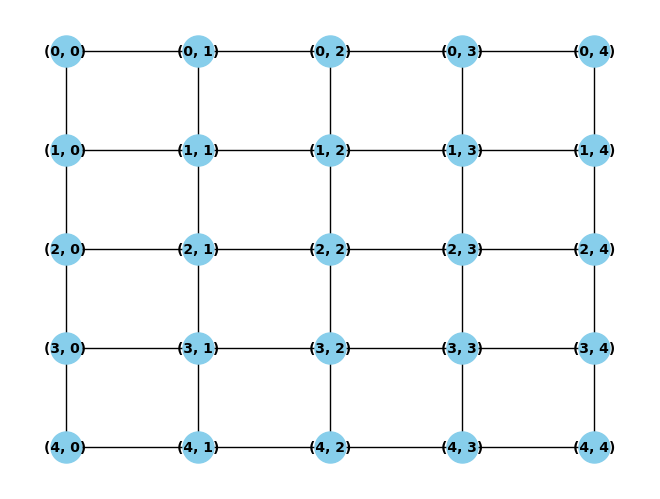

In [20]:
import networkx as nx

# Create node mappings
G = nx.grid_2d_graph(5, 5)

# convert to array
adjacency_matrix = nx.adjacency_matrix(G)
adjacency_matrix = adjacency_matrix.toarray()

# reshape to work with GNN and timeseries data
adjacency_matrix_train = np.repeat(adjacency_matrix[np.newaxis, :, :], train_size, axis=0)
adjacency_matrix_test = np.repeat(adjacency_matrix[np.newaxis, :, :], test_size, axis=0)

#------------------------------------------------------------------------------------------------------------------------------------------------
# Visualise the enviroment for verification
#------------------------------------------------------------------------------------------------------------------------------------------------

import matplotlib.pyplot as plt

# Plot the graph
pos = {(x, y): (y, -x) for x, y in G.nodes()}
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_color='black', font_weight='bold')

plt.axis('off')
plt.show()

### 4. Compile and fit model

In [21]:
import tensorflow as tf
from Intruder_functionality import machine_learning as ml

data_shape = (trainX.shape[1], trainX.shape[-1])
adjacency_shape = adjacency_matrix_train.shape[1:]

model = ml.ML_Intruder(data_shape, adjacency_shape)

# Compile the model
model.compile()

# Define the window size and threshold
window_size = 10
threshold = 0.99  # Example threshold

list_of_attacked_nodes = []
attack_outcomes = []
timestep = []

# Training loop
for i in range(window_size, trainX.shape[0]-1):
    # Get the most recent window of data
    window_data = trainX[i-window_size:i,:,:]

    attack_window = trainX[i+1,:,:]
    attack_window = attack_window[np.newaxis, ...]  # Add batch dimension

    # Get the corresponding label
    label = trainY[i-window_size:i,:]
    attack_label = trainY[i+1,:]

    print(i)

    # Train on the window data
    model.train_on_batch(window_data, label)

    # Predict on the window data
    prediction = model.predict(attack_window)

    max_index = prediction.argmax()

    print(prediction)
    print(prediction.max())
    print(attack_label)
    print(max_index)

    # Check the prediction against the threshold
    if (i>100) & (prediction.max() >= threshold):
        print(f"Threshold reached with prediction: {prediction.max()} at timestep: {i}")
        print(f"Attack succesful if value is 1, with the value being: {attack_label[max_index]} at timestep: {i}")
        list_of_attacked_nodes.append(max_index)
        attack_outcomes.append(attack_label[max_index])
        timestep.append(i+1)








10
1/1 [==============================] - 0s 90ms/step
[[5.9355929e-09 9.9232352e-01 2.3809060e-01 4.4059489e-04 9.6264529e-01
  5.0505128e-04 9.9656498e-01 6.7338777e-01 3.5607658e-04 9.6626526e-01
  9.9980193e-01 1.9165404e-01 9.9977255e-01 2.4113115e-03 9.9999899e-01
  7.3800081e-01 9.9994093e-01 9.9996132e-01 1.5237614e-06 6.1514544e-01
  5.0554529e-02 1.1397079e-05 1.0000000e+00 9.9997342e-01 4.1729492e-01]]
1.0
[0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1.]
22
11
1/1 [==============================] - 0s 25ms/step
[[4.7054729e-09 9.9276632e-01 1.7742981e-01 4.1513608e-04 9.7122043e-01
  3.6994411e-04 9.9510610e-01 5.7955527e-01 3.9159638e-04 9.5993960e-01
  9.9985445e-01 1.6187669e-01 9.9980122e-01 2.2861473e-03 9.9999899e-01
  6.9058734e-01 9.9993020e-01 9.9996358e-01 1.2223680e-06 5.9673637e-01
  4.3457106e-02 1.0589591e-05 1.0000000e+00 9.9998033e-01 4.3305996e-01]]
1.0
[0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1.]

### 5. Overall Performance Review 

/var/folders/b5/lyr1nzqx4kq7mbz3wsnfsxcw0000gn/T/ipykernel_56519/1309024716.py:44: RuntimeWarning: invalid value encountered in scalar divide
  train_total_list.append(train_success/(train_success+train_failed)*100)
/var/folders/b5/lyr1nzqx4kq7mbz3wsnfsxcw0000gn/T/ipykernel_56519/1309024716.py:47: RuntimeWarning: invalid value encountered in scalar divide
  test_total_list.append(test_success/(test_success+test_failed)*100)


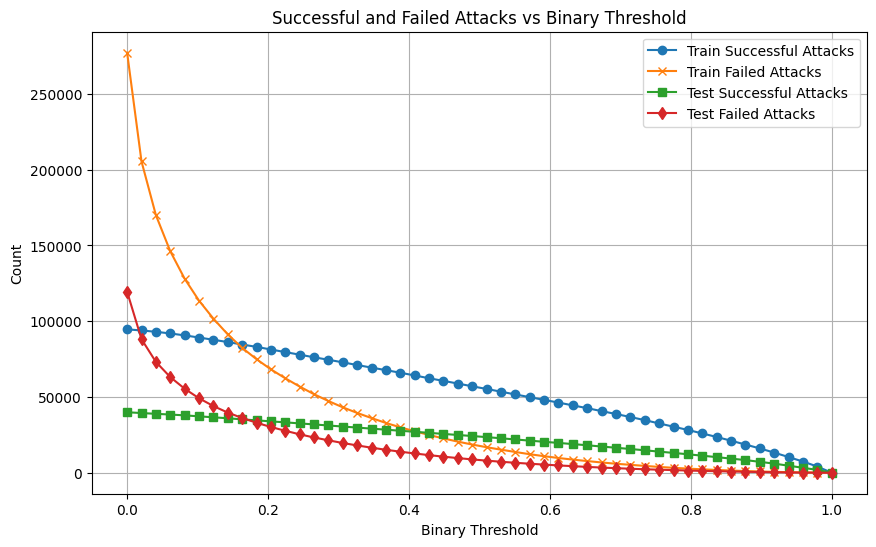

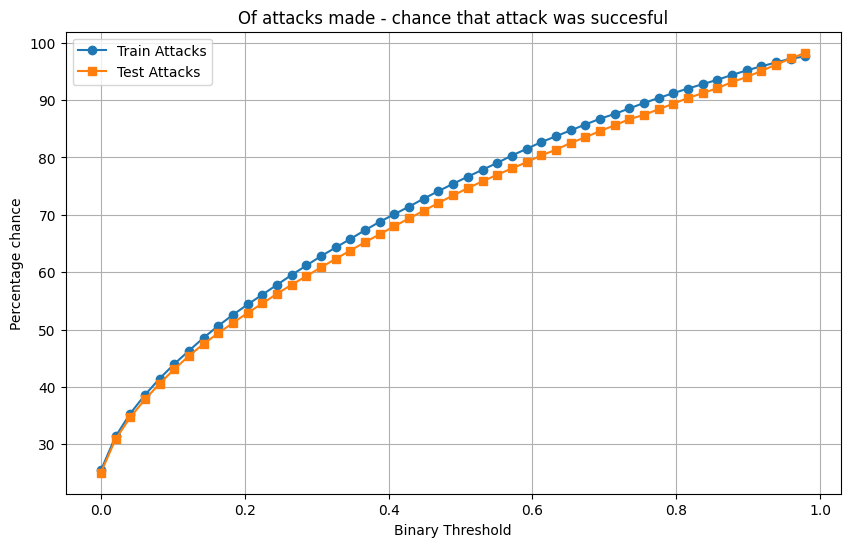

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(timestep, attack_outcomes, label='Train Attacks', marker='o')

plt.title('Outcome of attacks')
plt.xlabel('timestep')
plt.ylabel('label')
plt.legend()
plt.grid(True)
# plt.savefig("decay_learning_rate_0.001_success_fail.png")


# plt.figure(figsize=(10, 6))
# plt.plot(thresholds, train_total_list, label='Train Attacks', marker='o')
# plt.plot(thresholds, test_total_list, label='Test Attacks', marker='s')

# plt.title('Of attacks made - chance that attack was succesful')
# plt.xlabel('Binary Threshold')
# plt.ylabel('Percentage chance')
# plt.legend()
# plt.grid(True)
# plt.savefig("decay_learning_rate_0.001_%_chance.png")
plt.show()
